# Imports

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
### Imports
import pandas as pd
import numpy as np
import os
import cv2
import matplotlib.pyplot as plt
import datetime
from pathlib import Path
import gc
import warnings
warnings.filterwarnings("ignore")
import sys
import time
####
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score
from sklearn.metrics import accuracy_score
from sklearn.metrics import f1_score
from sklearn.metrics import precision_recall_fscore_support
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
####
import torch
import torch.nn as nn
from torch.utils.data import DataLoader
from torch.utils.data import Dataset
from torch import optim
import torchvision.transforms as transforms
import torchvision
##
from fastprogress import master_bar, progress_bar
from PIL import Image
gc.collect()

47

In [ ]:
print(time.strftime("%H:%M:%S",time.localtime()))

19:04:33


## Load the Data and Paths

In [ ]:
path="/content/drive/Othercomputers/Mac'im/"
out="/content/drive/MyDrive/DenseNet101/"

In [ ]:
chestxrays_root = Path(path)
data_path = chestxrays_root
####

full_train_df = pd.read_csv(path+'CheXpert-v1.0-small/train.csv')
full_valid_df = pd.read_csv(path+'CheXpert-v1.0-small/valid.csv')

full_train_df['patient'] = full_train_df.Path.str.split('/', n=3).str[2]
full_train_df['study'] = full_train_df.Path.str.split('/', n=4).str[3]

full_valid_df['patient'] = full_valid_df.Path.str.split('/', n=3).str[2]
full_valid_df['study'] = full_valid_df.Path.str.split('/', n=4).str[3]

print("Train Data : ",len(full_train_df))

full_train_df.head()

Train Data :  223414


,Path,Sex,Age,Frontal/Lateral,AP/PA,No Finding,Enlarged Cardiomediastinum,Cardiomegaly,Lung Opacity,Lung Lesion,...,Consolidation,Pneumonia,Atelectasis,Pneumothorax,Pleural Effusion,Pleural Other,Fracture,Support Devices,patient,study
0,CheXpert-v1.0-small/train/patient00001/study1/...,Female,68,Frontal,AP,1.0,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,0.0,NaN,NaN,NaN,1.0,patient00001,study1
1,CheXpert-v1.0-small/train/patient00002/study2/...,Female,87,Frontal,AP,NaN,NaN,-1.0,1.0,NaN,...,-1.0,NaN,-1.0,NaN,-1.0,NaN,1.0,NaN,patient00002,study2
2,CheXpert-v1.0-small/train/patient00002/study1/...,Female,83,Frontal,AP,NaN,NaN,NaN,1.0,NaN,...,-1.0,NaN,NaN,NaN,NaN,NaN,1.0,NaN,patient00002,study1
3,CheXpert-v1.0-small/train/patient00002/study1/...,Female,83,Lateral,NaN,NaN,NaN,NaN,1.0,NaN,...,-1.0,NaN,NaN,NaN,NaN,NaN,1.0,NaN,patient00002,study1
4,CheXpert-v1.0-small/train/patient00003/study1/...,Male,41,Frontal,AP,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,0.0,NaN,NaN,NaN,NaN,patient00003,study1


## Input Data Plots
### Analyze Input Data

In [ ]:
cols = ['No Finding', 'Enlarged Cardiomediastinum', 'Cardiomegaly',
       'Lung Opacity', 'Lung Lesion', 'Edema', 'Consolidation', 'Pneumonia',
       'Atelectasis', 'Pneumothorax', 'Pleural Effusion', 'Pleural Other',
       'Fracture', 'Support Devices']

data_df = []

for i in cols:
    minusOneVal = sum(np.where(full_train_df[i] == -1,1,0))
    oneVal = sum(np.where(full_train_df[i] == 1,1,0))
    zeroVal = sum(np.where(full_train_df[i] == 0,1,0))
    #nanVal = sum(np.where(full_train_df[i] == np.NaN ,1,0))
    nanVal = full_train_df[i].isnull().sum()
    data_df.append([i,minusOneVal,oneVal,zeroVal,nanVal])

data_df = pd.DataFrame(data_df)
data_df.columns = ['Label','minusOneVal','oneVal','zeroVal','nanVal']
data_df

,Label,minusOneVal,oneVal,zeroVal,nanVal
0,No Finding,0,22381,0,201033
1,Enlarged Cardiomediastinum,12403,10798,21638,178575
2,Cardiomegaly,8087,27000,11116,177211
3,Lung Opacity,5598,105581,6599,105636
4,Lung Lesion,1488,9186,1270,211470
5,Edema,12984,52246,20726,137458
6,Consolidation,27742,14783,28097,152792
7,Pneumonia,18770,6039,2799,195806
8,Atelectasis,33739,33376,1328,154971
9,Pneumothorax,3145,19448,56341,144480


### Plot input Data

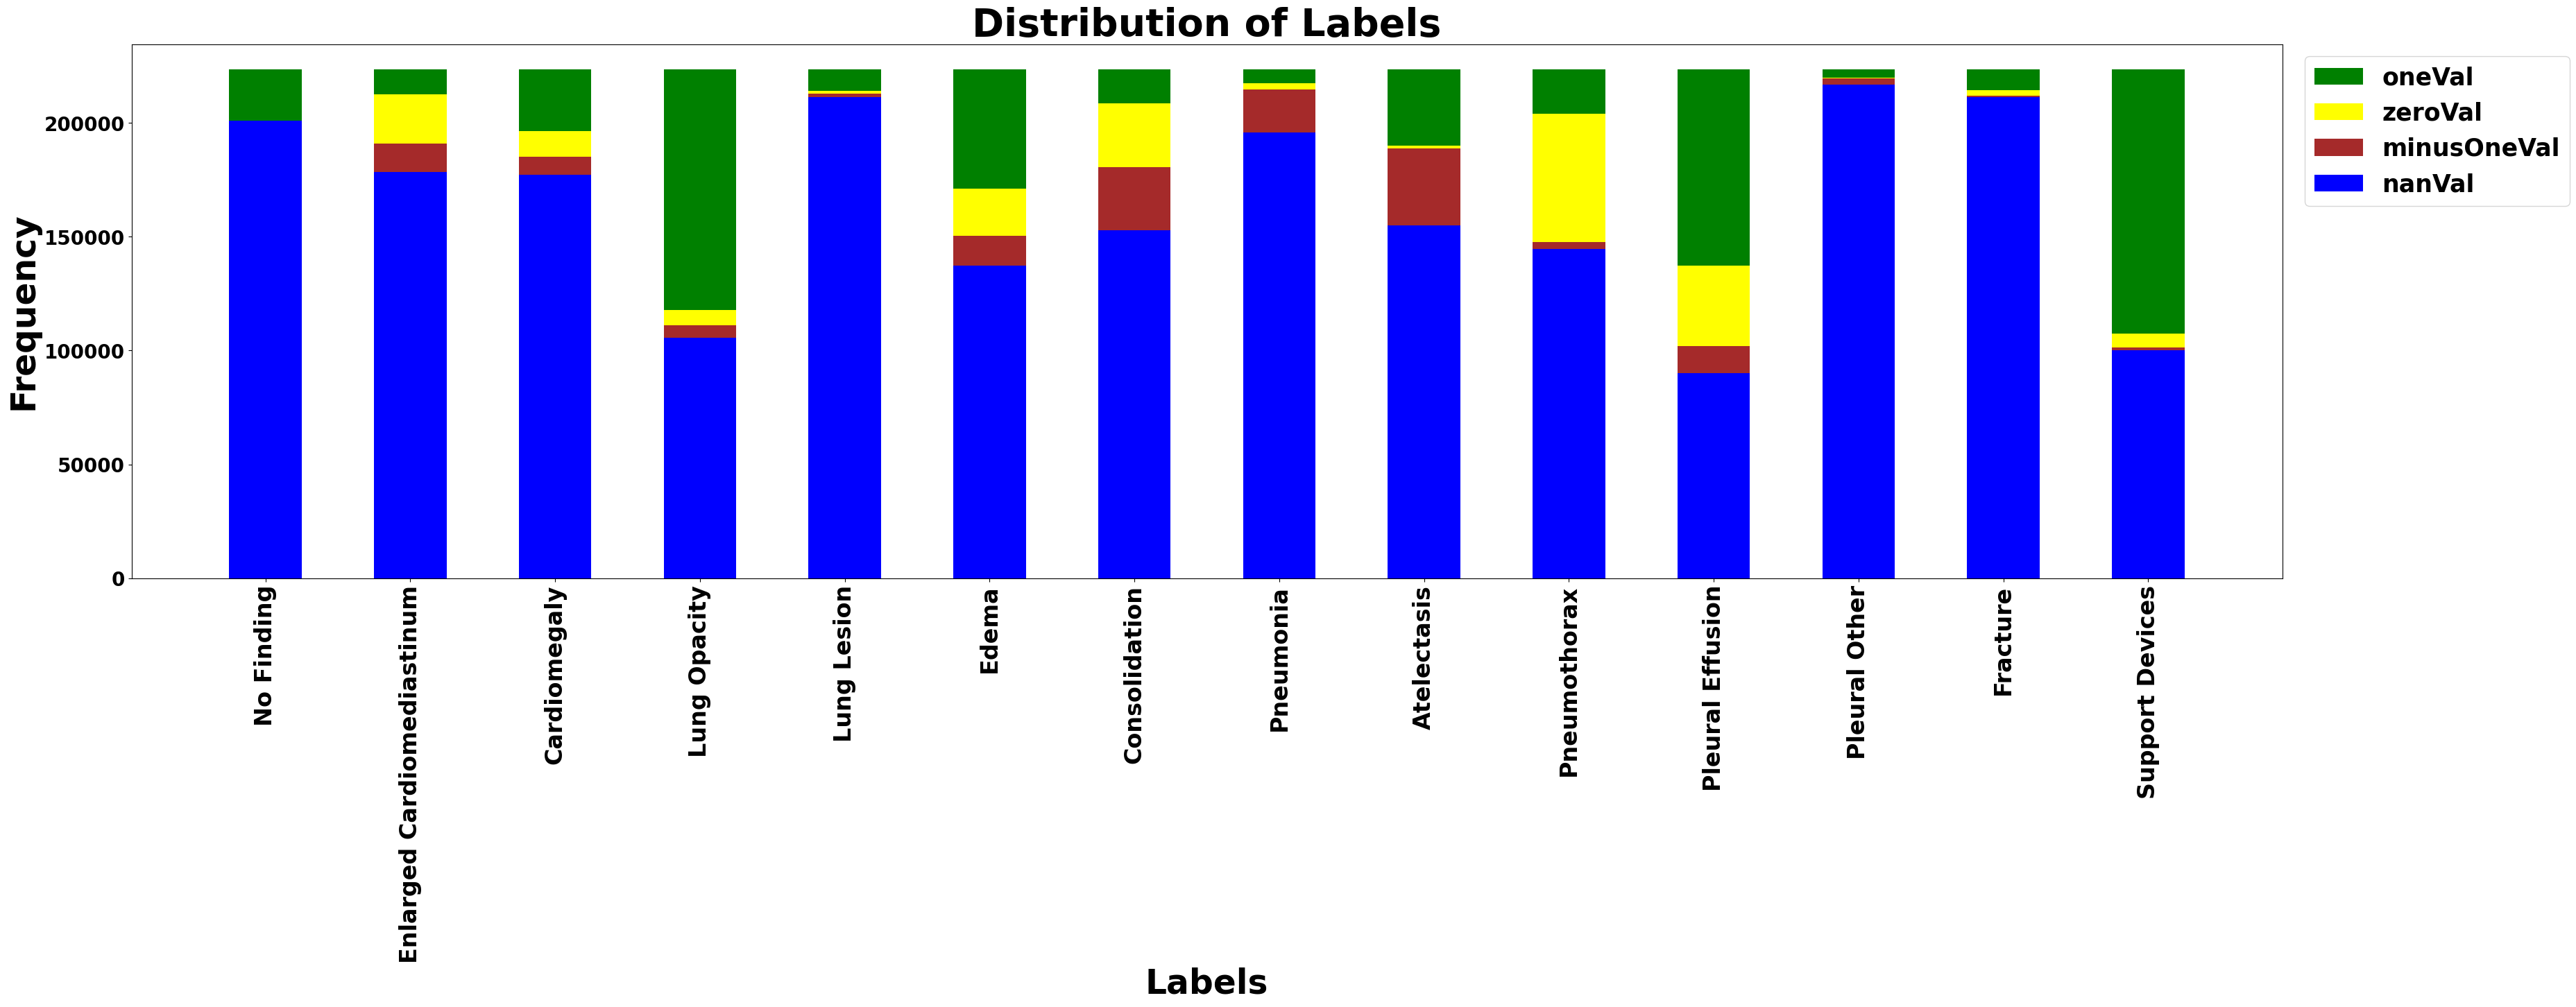

In [ ]:
plt.figure(figsize=(40,10))
Label = data_df['Label']
nanVal = data_df['nanVal']
minusOneVal = data_df['minusOneVal']
zeroVal = data_df['zeroVal']
oneVal = data_df['oneVal']

ind = [x for x, _ in enumerate(Label)]

plt.bar(Label, oneVal, width=0.5, label='oneVal', color='green', bottom=zeroVal+minusOneVal+nanVal)
plt.bar(Label, zeroVal, width=0.5, label='zeroVal', color='yellow', bottom=minusOneVal+nanVal)
plt.bar(Label, minusOneVal, width=0.5, label='minusOneVal', color='brown',bottom=nanVal)
plt.bar(Label, nanVal, width=0.5, label='nanVal', color='blue')

plt.yticks(fontsize=20,fontweight='bold')

plt.xticks(ind, Label,fontsize=24,fontweight='bold',rotation=90)
plt.ylabel("Frequency",fontsize=35,fontweight='bold')
plt.xlabel("Labels",fontsize=35,fontweight='bold')
plt.legend(bbox_to_anchor=(1.005, 1),fontsize=25)
#plt.legend(bbox_to_anchor=(1.005, 1))
plt.title("Distribution of Labels",fontsize=40, fontweight='bold')

plt.show()

## Handling Uncertainities - U_one and U_zero

Since this model is used as a first pass for chest x-ray diagnosis, false negative has higher cost and all uncertainties were
consdiered as positive (replaced -1 by 1)

In [ ]:
u_one_features = ['Atelectasis', 'Edema']
u_zero_features = ['Cardiomegaly', 'Consolidation', 'Pleural Effusion']

full_train_df['Cardiomegaly'] = full_train_df['Cardiomegaly'].replace(-1,0)
full_train_df['Consolidation'] = full_train_df['Consolidation'].replace(-1,0)
full_train_df['Pleural Effusion'] = full_train_df['Pleural Effusion'].replace(-1,0)

full_train_df['Atelectasis'] = full_train_df['Atelectasis'].replace(-1,1)
full_train_df['Edema'] = full_train_df['Edema'].replace(-1,1)
full_train_df = full_train_df.replace(-1,np.nan)
full_train_df.head()

,Path,Sex,Age,Frontal/Lateral,AP/PA,No Finding,Enlarged Cardiomediastinum,Cardiomegaly,Lung Opacity,Lung Lesion,...,Consolidation,Pneumonia,Atelectasis,Pneumothorax,Pleural Effusion,Pleural Other,Fracture,Support Devices,patient,study
0,CheXpert-v1.0-small/train/patient00001/study1/...,Female,68,Frontal,AP,1.0,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,0.0,NaN,NaN,NaN,1.0,patient00001,study1
1,CheXpert-v1.0-small/train/patient00002/study2/...,Female,87,Frontal,AP,NaN,NaN,0.0,1.0,NaN,...,0.0,NaN,1.0,NaN,0.0,NaN,1.0,NaN,patient00002,study2
2,CheXpert-v1.0-small/train/patient00002/study1/...,Female,83,Frontal,AP,NaN,NaN,NaN,1.0,NaN,...,0.0,NaN,NaN,NaN,NaN,NaN,1.0,NaN,patient00002,study1
3,CheXpert-v1.0-small/train/patient00002/study1/...,Female,83,Lateral,NaN,NaN,NaN,NaN,1.0,NaN,...,0.0,NaN,NaN,NaN,NaN,NaN,1.0,NaN,patient00002,study1
4,CheXpert-v1.0-small/train/patient00003/study1/...,Male,41,Frontal,AP,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,0.0,NaN,NaN,NaN,NaN,patient00003,study1


## Get Sample Data - Only to Run Test

In [ ]:
TEST_FLAG = 'N'
if TEST_FLAG == 'Y':
    sample_perc = 0.01
    unique_patients = full_train_df.patient.unique()
    mask = np.random.rand(len(unique_patients)) <= sample_perc
    sample_patients = unique_patients[mask]
    full_train_df = full_train_df[full_train_df.patient.isin(sample_patients)]

full_train_df = full_train_df.drop(['patient', 'study'],axis=1)
print(full_train_df.Path.size)

223414


## Get Labels

In [ ]:
LABELS = full_train_df.columns[5:]
LABELS

Index(['No Finding', 'Enlarged Cardiomediastinum', 'Cardiomegaly',
       'Lung Opacity', 'Lung Lesion', 'Edema', 'Consolidation', 'Pneumonia',
       'Atelectasis', 'Pneumothorax', 'Pleural Effusion', 'Pleural Other',
       'Fracture', 'Support Devices'],
      dtype='object')

# Split Test & Train

In [ ]:
############## -------- düzeltilecek tam veri için  -----------#############

train_data, val_data = train_test_split(full_train_df, test_size=0.20, random_state=2021)
del full_train_df
del full_valid_df
gc.collect()
print(train_data.Path.size)
print(val_data.Path.size)

178731
44683


### Pre Trained Models

In [ ]:

####################################################################################
###   DenseNet121
####################################################################################
#
class DenseNet121(nn.Module):
    def __init__(self, num_classes=14, is_trained=False):

        super().__init__()
        self.net = torchvision.models.densenet121(pretrained=is_trained)
        # Get the input dimension of last layer
        kernel_count = self.net.classifier.in_features
        self.net.classifier = nn.Sequential(nn.Linear(kernel_count, num_classes), nn.Sigmoid())

    def forward(self, inputs):
        """
        Forward the netword with the inputs
        """
        return self.net(inputs)



## Create Dataset

In [ ]:
class ChestXrayDataset(Dataset):

    def __init__(self, folder_dir, dataframe, image_size, normalization):
        """
        Init Dataset

        Parameters
        ----------
        folder_dir: str
            folder contains all images
        dataframe: pandas.DataFrame
            dataframe contains all information of images
        image_size: int
            image size to rescale
        normalization: bool
            whether applying normalization with mean and std from ImageNet or not
        """
        self.image_paths = [] # List of image paths
        self.image_labels = [] # List of image labels

        # Define list of image transformations
        image_transformation = [
            transforms.Resize((image_size, image_size)),
            transforms.ToTensor()
        ]

        self.image_transformation = transforms.Compose(image_transformation)

        # Get all image paths and image labels from dataframe
        for index, row in dataframe.iterrows():
            image_path = os.path.join(folder_dir, row.Path)
            self.image_paths.append(image_path)
            if len(row) < 14:
                labels = [0] * 14
            else:
                labels = []
                for col in row[5:]:
                    if col == 1:
                        labels.append(1)
                    else:
                        labels.append(0)
            self.image_labels.append(labels)

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, index):
        """
        Read image at index and convert to torch Tensor
        """

        # Read image
        image_path = self.image_paths[index]
        image_data = Image.open(image_path).convert("RGB") # Convert image to RGB channels

        # TODO: Image augmentation code would be placed here

        # Resize and convert image to torch tensor
        image_data = self.image_transformation(image_data)

        return image_data, torch.FloatTensor(self.image_labels[index])

## Training Parameters

In [ ]:
IMAGE_SIZE = 224                              # Image size (224x224)
BATCH_SIZE = 96
LEARNING_RATE = 0.001
LEARNING_RATE_SCHEDULE_FACTOR = 0.1           # Parameter used for reducing learning rate
LEARNING_RATE_SCHEDULE_PATIENCE = 5           # Parameter used for reducing learning rate
MAX_EPOCHS = 30 ##100                              # Maximum number of training epochs

## Training Data

### Train Loader

In [ ]:
my_data_path = path
train_dataset = ChestXrayDataset(my_data_path, train_data, IMAGE_SIZE, True)
#train_dataloader = DataLoader(dataset=train_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=4)
train_dataloader = DataLoader(dataset=train_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=4)
for data, label in train_dataloader:
    print(data.size())
    print(label.size())
    break

torch.Size([96, 3, 224, 224])
torch.Size([96, 14])


### Validation Loader

In [ ]:
val_dataset = ChestXrayDataset(my_data_path, val_data, IMAGE_SIZE, True)
#val_dataloader = DataLoader(dataset=val_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=4)
val_dataloader = DataLoader(dataset=val_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=4)

In [ ]:
del train_data
del val_data
del train_dataset
del val_dataset
gc.collect()

0

## Set Device

In [ ]:
device = "cuda" if torch.cuda.is_available() else "cpu"
if device == "cuda":
    torch.cuda.empty_cache()
device

'cuda'

## Evaluation Metrics

### AUROC
### Accuracy
### f1 score
### Precision and Recall

In [ ]:
def multi_label_auroc(y_gt, y_pred):
    """ Calculate AUROC for each class

    Parameters
    ----------
    y_gt: torch.Tensor
        groundtruth
    y_pred: torch.Tensor
        prediction

    Returns
    -------
    list
        F1 of each class
    """
    auroc = []
    gt_np = y_gt.to("cpu").numpy()
    pred_np = y_pred.to("cpu").numpy()
    assert gt_np.shape == pred_np.shape, "y_gt and y_pred should have the same size"
    for i in range(gt_np.shape[1]):
        try:
            auroc.append(roc_auc_score(gt_np[:, i], pred_np[:, i]))
        except ValueError:
            pass
    return auroc

def multi_label_accuracy(y_gt, y_pred):
    """ Calculate AUROC for each class

    Parameters
    ----------
    y_gt: torch.Tensor
        groundtruth
    y_pred: torch.Tensor
        prediction

    Returns
    -------
    list
        F1 of each class
    """
    acc = []
    gt_np = y_gt.to("cpu").numpy()
    pred_np = y_pred.to("cpu").numpy()
    assert gt_np.shape == pred_np.shape, "y_gt and y_pred should have the same size"
    for i in range(gt_np.shape[1]):
        acc.append(accuracy_score(gt_np[:, i], np.where(pred_np[:, i]>=0.5,1,0)))
    return acc

def multi_label_f1(y_gt, y_pred):
    """ Calculate f1 for each class

    Parameters
    ----------
    y_gt: torch.Tensor
        groundtruth
    y_pred: torch.Tensor
        prediction

    Returns
    -------
    list
        F1 of each class
    """
    f1_out = []
    gt_np = y_gt.to("cpu").numpy()
    pred_np = y_pred.to("cpu").numpy()
    assert gt_np.shape == pred_np.shape, "y_gt and y_pred should have the same size"
    for i in range(gt_np.shape[1]):
        f1_out.append(f1_score(gt_np[:, i], np.where(pred_np[:, i]>=0.5,1,0)))
    return f1_out


def multi_label_precision_recall(y_gt, y_pred):
    """ Calculate precision for each class

    Parameters
    ----------
    y_gt: torch.Tensor
        groundtruth
    y_pred: torch.Tensor
        prediction

    Returns
    -------
    list
        precision of each class
    """
    precision_out = []
    recall_out = []
    gt_np = y_gt.to("cpu").numpy()
    pred_np = y_pred.to("cpu").numpy()
    assert gt_np.shape == pred_np.shape, "y_gt and y_pred should have the same size"
    for i in range(gt_np.shape[1]):
        p = precision_recall_fscore_support(gt_np[:, i], np.where(pred_np[:, i]>=0.5,1,0),average='binary')
        precision_out.append(p[0])
        recall_out.append(p[1])
    return precision_out,recall_out

**Training Function**

In [ ]:
def epoch_training(epoch, model, train_dataloader, device, loss_criteria, optimizer, mb):
    """
    Epoch training

    Paramteters
    -----------
    epoch: int
      epoch number
    model: torch Module
      model to train
    train_dataloader: Dataset
      data loader for training
    device: str
      "cpu" or "cuda"
    loss_criteria: loss function
      loss function used for training
    optimizer: torch optimizer
      optimizer used for training
    mb: master bar of fastprogress
      progress to log

    Returns
    -------
    float
      training loss
    """
    # Switch model to training mode
    model.train()
    training_loss = 0 # Storing sum of training losses

    # For each batch
    for batch, (images, labels) in enumerate(progress_bar(train_dataloader, parent=mb)):

        # Move X, Y  to device (GPU)
        images = images.to(device)
        labels = labels.to(device)

        # Clear previous gradient
        optimizer.zero_grad()

        # Feed forward the model
        pred = model(images)
        #pred = torch.LongTensor(pred)
        loss = loss_criteria(pred, labels)
        #print("loss is ",loss)

        # Back propagation
        loss.backward()

        # Update parameters
        optimizer.step()

        # Update training loss after each batch
        training_loss += loss.item()

        #mb.child.comment = f'Training loss {training_loss/(batch+1)}'

    del images, labels, loss
    if torch.cuda.is_available(): torch.cuda.empty_cache()

    # return training loss
    return training_loss/len(train_dataloader)

**Evaluating Function**

In [ ]:
def evaluating(epoch, model, val_loader, device, loss_criteria, mb):
    """
    Validate model on validation dataset

    Parameters
    ----------
    epoch: int
        epoch number
    model: torch Module
        model used for validation
    val_loader: Dataset
        data loader of validation set
    device: str
        "cuda" or "cpu"
    loss_criteria: loss function
        loss function used for training
    mb: master bar of fastprogress
        progress to log

    Returns
    -------
    float
        loss on validation set
    float
        AUROC score
    float
        accuracy
    float
        F1 score
    """

    model.eval()

    val_loss = 0
    out_pred = []
    out_gt = []

    with torch.no_grad():
        for step, (images, labels) in enumerate(progress_bar(val_loader, parent=mb)):
            images = images.to(device)
            labels = labels.to(device)

            ps = model(images)
            loss = loss_criteria(ps, labels)

            val_loss += loss.item()

            # Append tensors to lists without detaching and converting to NumPy
            out_pred.append(ps)
            out_gt.append(labels)

    # Concatenate tensors and move to CPU
    out_pred = torch.cat(out_pred).cpu()
    out_gt = torch.cat(out_gt).cpu()

    if torch.cuda.is_available():
        torch.cuda.empty_cache()

    val_loss_mean = val_loss / len(val_loader)

    # Call multi_label_auroc with tensors
    auroc_mean = np.nanmean(np.array(multi_label_auroc(out_gt, out_pred)))
    acc_mean = np.nanmean(np.array(multi_label_accuracy(out_gt, out_pred)))
    f1_mean = np.nanmean(np.array(multi_label_f1(out_gt, out_pred)))

    return val_loss_mean, auroc_mean, acc_mean, f1_mean

**Define Optimizer**

In [ ]:
def get_opt(modeltxt,model):

    if modeltxt == "DenseNet121":
        return optim.Adam(model.parameters(), lr=LEARNING_RATE, betas=(0.9, 0.999), eps=1e-8, weight_decay=1e-5)


# Train Model

In [ ]:
def trainModel(modelname,loss_criteria,modeltxt):
    model = modelname(num_classes=len(LABELS),is_trained=True).to(device)

    optimizer = get_opt(modeltxt,model)
    # Learning rate will be reduced automatically during training
    lr_scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, factor = LEARNING_RATE_SCHEDULE_FACTOR,
                                                        patience = LEARNING_RATE_SCHEDULE_PATIENCE, mode = 'max', verbose=True)
    best_score = 0
    best_score_acc = 0
    best_score_f1 = 0

    model_path = out+modeltxt+".pth"
    out_path = out+modeltxt+"_running.csv"
    training_losses = []
    validation_losses = []
    validation_score = []
    validation_acc = []
    validation_f1 = []


    # Config progress bar
    mb = master_bar(range(MAX_EPOCHS))
    mb.names = ['Train loss', 'Val loss', 'AUROC', 'Accuracy', 'f1 score']
    x = []

    nonimproved_epoch = 0
    start_time = time.time()
    cnt = 1

    # Training each epoch
    for epoch in mb:
        #break
        mb.main_bar.comment = f'Best AUROC score: {best_score}'
        x.append(epoch)

        # Training
        train_loss = epoch_training(epoch, model, train_dataloader, device, loss_criteria, optimizer, mb)
        mb.write('Finish training epoch {} with loss {:.4f}'.format(epoch, train_loss))
        training_losses.append(train_loss)

        # Evaluating
        val_loss, new_score, new_score_acc, new_score_f1 = evaluating(epoch, model, val_dataloader, device, loss_criteria, mb)

        validation_losses.append(val_loss)
        validation_score.append(new_score)
        validation_acc.append(new_score_acc)
        validation_f1.append(new_score_f1)

        gc.collect()
        # Update learning rate
        lr_scheduler.step(new_score)

        # Update training chart
        mb.update_graph([[x, training_losses], [x, validation_losses], [x, validation_score] , [x, validation_acc] ,
                         [x, validation_f1]],
                        [0,epoch+1+round(epoch*0.3)], [0,1])

        diff = np.round(time.time() - start_time)
        pd.DataFrame([[epoch,modeltxt,best_score,new_score,diff]]).to_csv(out_path,index=False,mode='a',header=False)
        # Save model
        t2 = 4
        if modeltxt == 'DenseNet121':
            t2 = 6
        if best_score < new_score:
            #mb.write(f"Improve AUROC from {best_score} to {new_score}")
            best_score = new_score
            best_score_acc = new_score_acc
            best_score_f1 = new_score_f1
            nonimproved_epoch = 0
            best_model = model
            torch.save({"model": model.state_dict(),
                        "optimizer": optimizer.state_dict(),
                        "best_score": best_score,
                        "epoch": epoch,
                        "lr_scheduler": lr_scheduler.state_dict()}, model_path)
        else:
            nonimproved_epoch += 1
        if nonimproved_epoch > 5:
            break
            print("Early stopping")
        if time.time() - start_time > 3600*t2:
            break
            print("Out of time")


    return best_score,best_score_acc,best_score_f1,best_model


## Set Models to Train

In [ ]:
model_list = [DenseNet121]
mName_list = ['DenseNet121']

## Train Models in a Loop

Processing Model  DenseNet121


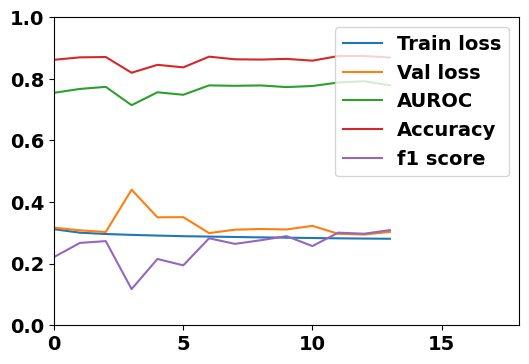

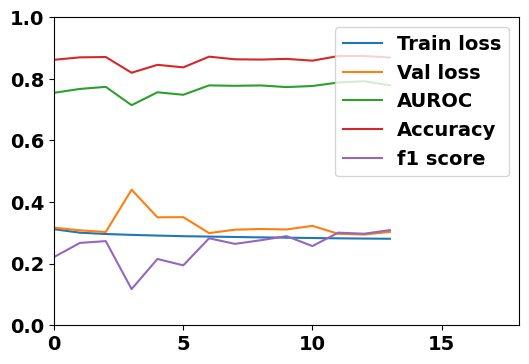

In [ ]:
eval_df_train = []
for m in model_list:
    mName = m().__class__.__name__
    print("Processing Model ",mName)
    globals()[f"best_score_{mName}"],globals()[f"best_score_acc_{mName}"],globals()[f"best_score_f1_{mName}"],globals()[f"best_model_{mName}"] = trainModel(modelname=m,loss_criteria=nn.BCELoss(),modeltxt=mName)
    #
    eval_df_train.append([mName,globals()[f"best_score_{mName}"],globals()[f"best_score_acc_{mName}"],globals()[f"best_score_f1_{mName}"]])

## Evaluation Results

In [ ]:
eval_df_train=pd.DataFrame(eval_df_train)
eval_df_train.columns = ['Model Name','AUROC', 'Accuracy', 'f1 Score']
eval_df_train.to_csv(out+"eval_df_train.csv",index=False)
eval_df_train

,Model Name,AUROC,Accuracy,f1 Score
0,DenseNet121,0.792455,0.874182,0.297233


## Best model Parameters

In [ ]:
def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

def count_parameters_all(model):
    return sum(p.numel() for p in model.parameters())

param_list = []
i = 0
for model in model_list:
    modelName = model().__class__.__name__
    num_params_all = count_parameters_all(model())
    num_params = count_parameters(model())
    param_list.append([modelName,num_params_all,num_params])

param_list=pd.DataFrame(param_list)
param_list.columns = ['Model Name','Total Parameters','Trainable Parameters']
param_list

,Model Name,Total Parameters,Trainable Parameters
0,DenseNet121,6968206,6968206


In [ ]:
del train_dataloader
del val_dataloader
gc.collect()

4099

# TESTING AND PREDICTION - Based on Unseen Test Data

In [ ]:
full_test_df = pd.read_csv(path+'CheXpert-v1.0-small/valid.csv')

## Test Data Distribution

In [ ]:
apcols = ['No Finding', 'Enlarged Cardiomediastinum', 'Cardiomegaly',
       'Lung Opacity', 'Lung Lesion', 'Edema', 'Consolidation', 'Pneumonia',
       'Atelectasis', 'Pneumothorax', 'Pleural Effusion', 'Pleural Other',
       'Fracture', 'Support Devices']

data_df = []

for i in cols:
    minusOneVal = sum(np.where(full_test_df[i] == -1,1,0))
    oneVal = sum(np.where(full_test_df[i] == 1,1,0))
    zeroVal = sum(np.where(full_test_df[i] == 0,1,0))
    nanVal = full_test_df[i].isnull().sum()
    data_df.append([i,minusOneVal,oneVal,zeroVal,nanVal])

data_df = pd.DataFrame(data_df)

data_df.columns = ['Label','minusOneVal','oneVal','zeroVal','nanVal']
data_df

,Label,minusOneVal,oneVal,zeroVal,nanVal
0,No Finding,0,38,196,0
1,Enlarged Cardiomediastinum,0,109,125,0
2,Cardiomegaly,0,68,166,0
3,Lung Opacity,0,126,108,0
4,Lung Lesion,0,1,233,0
5,Edema,0,45,189,0
6,Consolidation,0,33,201,0
7,Pneumonia,0,8,226,0
8,Atelectasis,0,80,154,0
9,Pneumothorax,0,8,226,0


## Test Data Plot

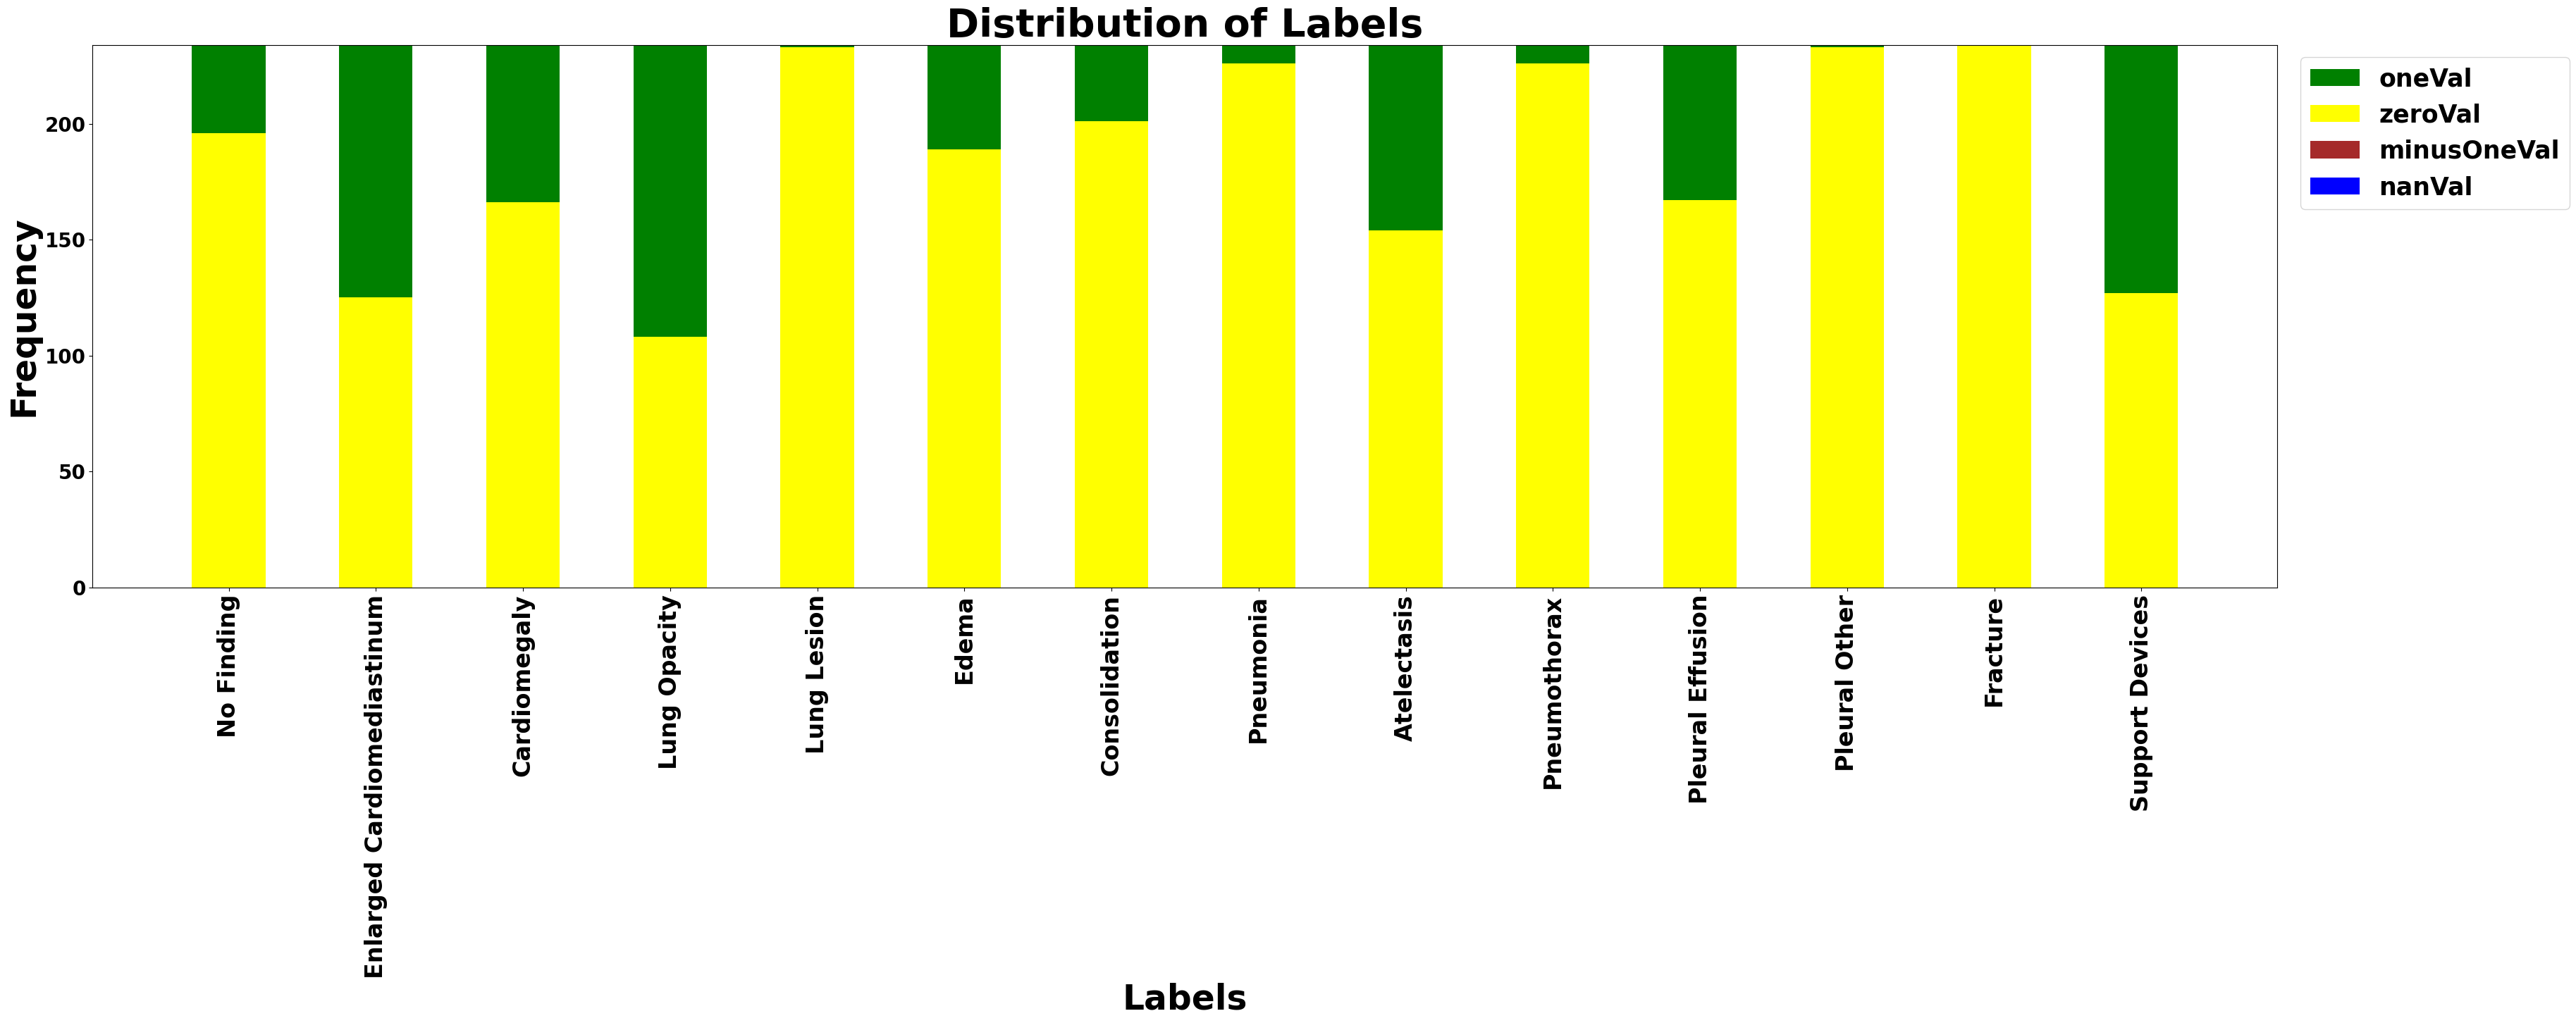

In [ ]:
plt.figure(figsize=(40,10))
Label = data_df['Label']
nanVal = data_df['nanVal']
minusOneVal = data_df['minusOneVal']
zeroVal = data_df['zeroVal']
oneVal = data_df['oneVal']

ind = [x for x, _ in enumerate(Label)]

plt.bar(Label, oneVal, width=0.5, label='oneVal', color='green', bottom=zeroVal+minusOneVal+nanVal)
plt.bar(Label, zeroVal, width=0.5, label='zeroVal', color='yellow', bottom=minusOneVal+nanVal)
plt.bar(Label, minusOneVal, width=0.5, label='minusOneVal', color='brown',bottom=nanVal)
plt.bar(Label, nanVal, width=0.5, label='nanVal', color='blue')

plt.yticks(fontsize=20,fontweight='bold')

plt.xticks(ind, Label,fontsize=24,fontweight='bold',rotation=90)
plt.ylabel("Frequency",fontsize=35,fontweight='bold')
plt.xlabel("Labels",fontsize=35,fontweight='bold')
plt.legend(bbox_to_anchor=(1.005, 1),fontsize=25)
#plt.legend(bbox_to_anchor=(1.005, 1))
plt.title("Distribution of Labels",fontsize=40, fontweight='bold')

plt.show()

In [ ]:
full_test_df.size

4446

## Test Data Loader

In [ ]:
BATCH_SIZE = 1
test_dataset = ChestXrayDataset(my_data_path, full_test_df, IMAGE_SIZE, True)
#test_dataloader = DataLoader(dataset=test_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=8)
test_dataloader = DataLoader(dataset=test_dataset, batch_size=BATCH_SIZE, shuffle=False)
for data, label in test_dataloader:
    print(data.size())
    print(label.size())
    break

torch.Size([1, 3, 224, 224])
torch.Size([1, 14])


In [ ]:
del test_dataset
del full_test_df
gc.collect()

6973

### Functions for Prediction, Confusion Matrix and Plots

In [ ]:
def getTestPreds(best_model,test_dataloader,modeltxt):
    y_pred_t = torch.FloatTensor().to(device)      # Tensor stores prediction values
    y_test_t = torch.FloatTensor().to(device)        # Tensor stores groundtruth values

    y_pred_list = []
    y_test_list = []

    test_auroc = []
    test_acc = []
    test_f1 = []
    test_precision = []
    test_recall = []

    with torch.no_grad():

        best_model.eval()
        for X_batch, labels in test_dataloader:
            X_batch = X_batch.to(device)
            labels = labels.to(device)

            ps = best_model(X_batch)

            y_test_t = torch.cat((y_test_t,  labels), 0)
            y_pred_t = torch.cat((y_pred_t, ps), 0)

            test_acc.append(np.mean(multi_label_accuracy(y_test_t, y_pred_t)))
            test_f1.append(np.mean(multi_label_f1(y_test_t, y_pred_t)))
            test_auroc.append(np.mean(multi_label_auroc(y_test_t, y_pred_t)))

            p,r = multi_label_precision_recall(y_test_t, y_pred_t)
            test_precision.append(np.mean(p))
            test_recall.append(np.mean(r))

        test_auroc = np.nanmean(test_auroc)
        test_acc = np.nanmean(test_acc)
        test_f1 = np.nanmean(test_f1)
        test_precision = np.nanmean(test_precision)
        test_recall = np.nanmean(test_recall)


        print("AUROC : ",test_auroc)
        print("Accuracy : ",test_acc)
        print("f1 score : ",test_f1)
        print("precision score : ",test_precision)
        print("recall score : ",test_recall)

        eval_matrix = [modeltxt,test_auroc,test_acc,test_f1,test_precision,test_recall]

        return y_test_t,y_pred_t,eval_matrix

############## Plot
def plot_conf(y_test,y_pred,modeltxt):
    f, axes = plt.subplots(2, 7, figsize=(25, 8))
    f.suptitle('Confustion Matrix For Model '+ modeltxt, fontsize=20, fontweight='bold')
    plt.rcParams.update({'font.size': 14,'font.weight': 'bold'})
    y_test = y_test.cpu()
    y_pred = np.where(y_pred.cpu()>0.5,1,0)
    axes = axes.ravel()
    for i in range(14):
        disp = ConfusionMatrixDisplay(confusion_matrix(y_test[:, i],
                                                       y_pred[:, i]))
        disp.plot(ax=axes[i], values_format='.10g')
        disp.ax_.set_title(f'{LABELS[i]}')
        disp.im_.colorbar.remove()

    plt.subplots_adjust(wspace=0.25, hspace=0.25)
    plt.show()

################# Get Values

def get_conf(y_test,y_pred,modeltxt):
    conf_vals = []
    y_test = y_test.cpu()
    y_pred = np.where(y_pred.cpu()>0.5,1,0)
    for i in range(14):
        c = confusion_matrix(y_test[:, i],y_pred[:, i])
        #p = c[0][0]
        #q = c[0][1]
        #r = c[1][0]
       # s = c[1][1]
        try:
            p = c[0][0]
        except IndexError:
            p = 0

        try:
            q = c[0][1]
        except IndexError:
            q = 0

        try:
            r = c[1][0]
        except IndexError:
            r = 0

        try:
            s = c[1][1]
        except IndexError:
            s = 0

        conf_vals.append([modeltxt,LABELS[i],p,q,r,s])

    return conf_vals

## Test Predictions

In [ ]:
eval_matrix_all = []
for mName in mName_list:
    print("Predicting for Model ",mName)
    globals()[f"y_test_t_{mName}"],globals()[f"y_pred_t_{mName}"],eval_matrix = getTestPreds(globals()[f"best_model_{mName}"],test_dataloader,mName)
    eval_matrix_all.append(eval_matrix)
    print("----------------------------------------------")

Predicting for Model  DenseNet121
AUROC :  nan
Accuracy :  0.8611739886075152
f1 score :  0.2656682102221652
precision score :  0.36958024881106716
recall score :  0.24604039868575667
----------------------------------------------


## Print and Plot Evaluation Matrices

### Print AUROC, Accuracy, F1 Score, Precision and Recall

In [ ]:
df_mat_all = pd.DataFrame(eval_matrix_all)
df_mat_all.columns = ["Model Name","AUROC","Accuracy","F1 Score","Precision","Recall"]
df_mat_all

,Model Name,AUROC,Accuracy,F1 Score,Precision,Recall
0,DenseNet121,NaN,0.861174,0.265668,0.36958,0.24604


### Print Accuracy for Labels

In [ ]:
label_list_all = []
for mName in mName_list:
    #print("Model ",mName)
    for i in range(14):
        acc = accuracy_score(globals()[f"y_test_t_{mName}"].to("cpu").numpy()[:, i], np.where(globals()[f"y_pred_t_{mName}"].to("cpu").numpy()[:, i]>=0.5,1,0))
        p = precision_recall_fscore_support(globals()[f"y_test_t_{mName}"].to("cpu").numpy()[:, i], np.where(globals()[f"y_pred_t_{mName}"].to("cpu").numpy()[:, i]>=0.5,1,0),average='binary')
        #print(LABELS[i]," ==> ","Acc : ",acc," Precision : ",p[0]," Recall : ",p[1])
        if i !=12:
            auroc = roc_auc_score(globals()[f"y_test_t_{mName}"].to("cpu").numpy()[:, i], globals()[f"y_pred_t_{mName}"].to("cpu").numpy()[:, i])
        else:
            auroc = np.nan

        #print(LABELS[i],p)
        label_list_all.append([mName,LABELS[i],auroc,acc,p[0],p[1]])


df_label_list_all = pd.DataFrame(label_list_all)
df_label_list_all.columns = ["Model Name","Label","AUROC","Accuracy","Precision","Recall"]
df_label_list_all.to_csv(out+"df_label_list_all.csv",index=False)
df_label_list_all

,Model Name,Label,AUROC,Accuracy,Precision,Recall
0,DenseNet121,No Finding,0.837809,0.841880,0.600000,0.078947
1,DenseNet121,Enlarged Cardiomediastinum,0.634202,0.534188,0.000000,0.000000
2,DenseNet121,Cardiomegaly,0.832831,0.756410,1.000000,0.161765
3,DenseNet121,Lung Opacity,0.895576,0.816239,0.895238,0.746032
4,DenseNet121,Lung Lesion,0.489270,0.995726,0.000000,0.000000
5,DenseNet121,Edema,0.911111,0.867521,0.733333,0.488889
6,DenseNet121,Consolidation,0.902307,0.858974,0.000000,0.000000
7,DenseNet121,Pneumonia,0.773783,0.965812,0.000000,0.000000
8,DenseNet121,Atelectasis,0.775162,0.662393,0.509804,0.325000
9,DenseNet121,Pneumothorax,0.869469,0.940171,0.250000,0.375000


## AUROC of Labels accross Different Models

In [ ]:
df_label_list_all.pivot(index='Label', columns='Model Name', values=["AUROC"])

,AUROC
Model Name,DenseNet121
Label,
Atelectasis,0.775162
Cardiomegaly,0.832831
Consolidation,0.902307
Edema,0.911111
Enlarged Cardiomediastinum,0.634202
Fracture,NaN
Lung Lesion,0.489270
Lung Opacity,0.895576


## Accuracy of Labels accross Different Models

In [ ]:
df_label_list_all.pivot(index='Label', columns='Model Name', values=["Accuracy"])

,Accuracy
Model Name,DenseNet121
Label,
Atelectasis,0.662393
Cardiomegaly,0.756410
Consolidation,0.858974
Edema,0.867521
Enlarged Cardiomediastinum,0.534188
Fracture,0.987179
Lung Lesion,0.995726
Lung Opacity,0.816239


## Precision of Labels accross Different Models

In [ ]:
df_label_list_all.pivot(index='Label', columns='Model Name', values=["Precision"])

,Precision
Model Name,DenseNet121
Label,
Atelectasis,0.509804
Cardiomegaly,1.000000
Consolidation,0.000000
Edema,0.733333
Enlarged Cardiomediastinum,0.000000
Fracture,0.000000
Lung Lesion,0.000000
Lung Opacity,0.895238


In [ ]:
df_label_list_all.pivot(index='Label', columns='Model Name', values=["Recall"])

,Recall
Model Name,DenseNet121
Label,
Atelectasis,0.325000
Cardiomegaly,0.161765
Consolidation,0.000000
Edema,0.488889
Enlarged Cardiomediastinum,0.000000
Fracture,0.000000
Lung Lesion,0.000000
Lung Opacity,0.746032


### Print Confusion Matrix

In [ ]:
conf_all = pd.DataFrame()
for mName in mName_list:
    print("Print Confusion Matrix for Model ",mName)
    # Use pd.concat instead of append
    conf_all = pd.concat([conf_all, pd.DataFrame(get_conf(globals()[f"y_test_t_{mName}"],globals()[f"y_pred_t_{mName}"],mName))], ignore_index=True)

Print Confusion Matrix for Model  DenseNet121


In [ ]:
conf_all.columns = ["Model Name","Label","True Negative","False Positive","False Negative","True Positive"]
conf_all.to_csv("ConfusionMatrix.csv",index=False)
conf_all_piv = conf_all.pivot(index='Label', columns='Model Name', values=["True Negative","False Positive","False Negative","True Positive"])
conf_all_piv.to_csv(out+"ConfusionMatrixPivot.csv",index=False)
conf_all_piv

,True Negative,False Positive,False Negative,True Positive
Model Name,DenseNet121,DenseNet121,DenseNet121,DenseNet121
Label,,,,
Atelectasis,129,25,54,26
Cardiomegaly,166,0,57,11
Consolidation,201,0,33,0
Edema,181,8,23,22
Enlarged Cardiomediastinum,125,0,109,0
Fracture,231,3,0,0
Lung Lesion,233,0,1,0
Lung Opacity,97,11,32,94


### Plot Confusion Matrix

Plot Confusion Matrix for Model  DenseNet121


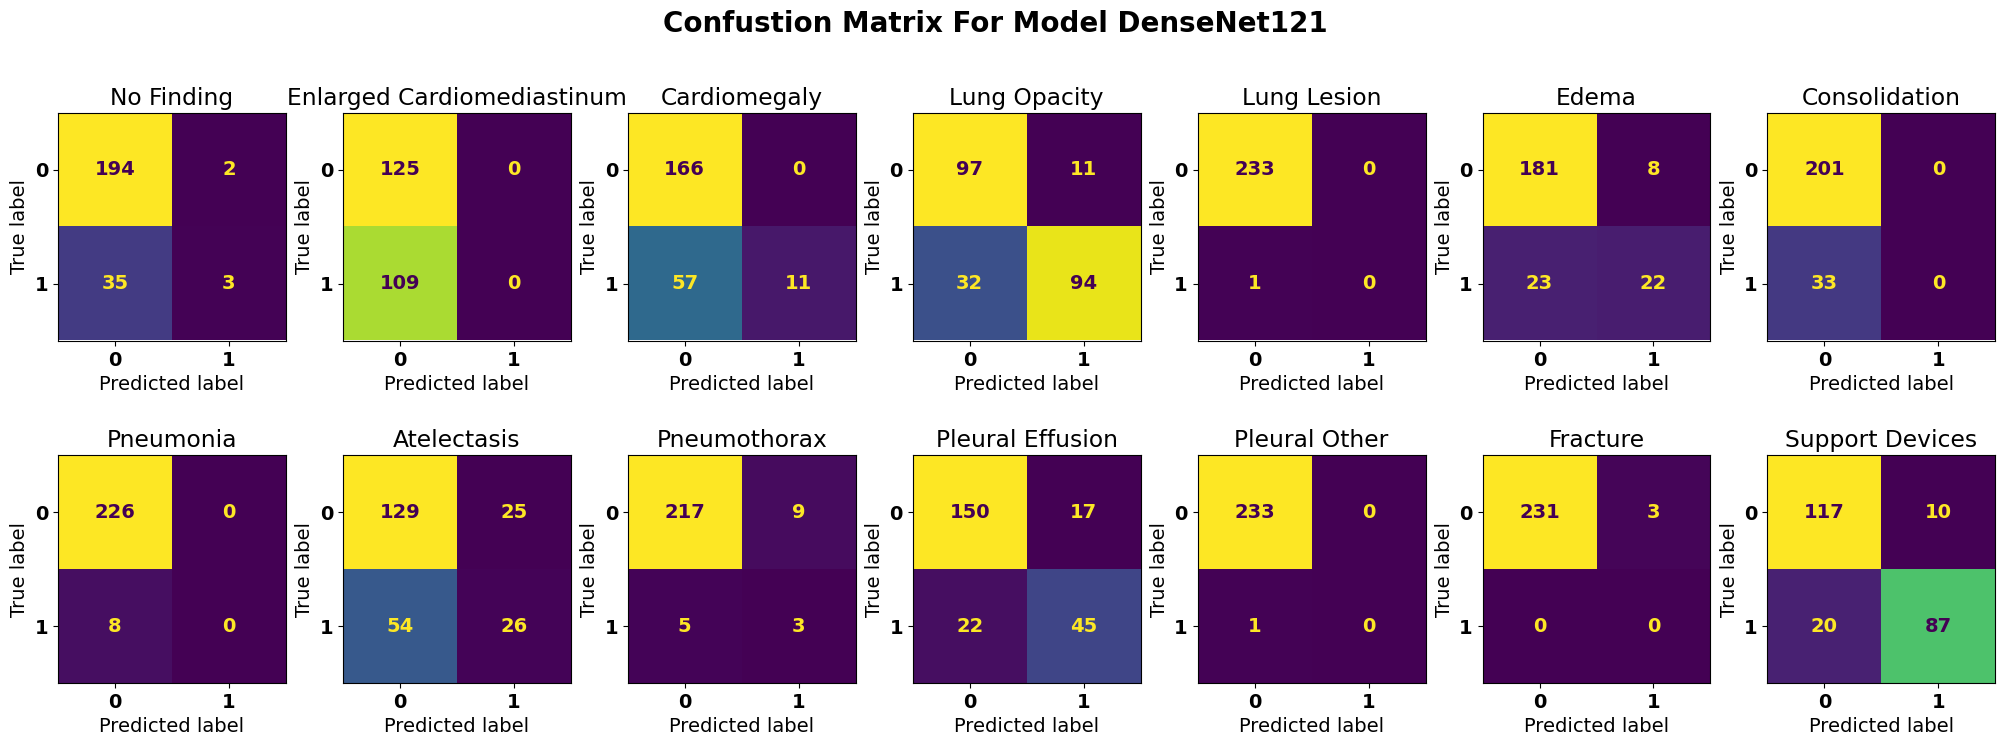

In [ ]:
conf_all = pd.DataFrame()
for mName in mName_list:
    print("Plot Confusion Matrix for Model ",mName)
    plot_conf(globals()[f"y_test_t_{mName}"],globals()[f"y_pred_t_{mName}"],mName)

In [ ]:
# Assuming 'best_model_DenseNet121' holds the trained model instance
torch.save(best_model_DenseNet121.state_dict(), "DenseNet121_model.pth")